K-means is a quit easy and one of the fastest clustering algorithms. One drawback of k-means is, that it will end up in a local optimum. That’s why it can be useful to restart it several times resulting in different models.

Examples of k-means clustering for different types of data:
- [Blobs (numerical)](#Nummerical-clustering)
- [MNIST (images)](#Image-clustering)
- [IMDB (text)](#Text-clustering)

I trained the model in a unsupervised way. Finally I checked if the model can classify inputs into target categories. 

If you would like to experience with another cluster methods or get a deeper insight check out the documentation of sklearn:
- https://scikit-learn.org/stable/modules/clustering.html

__________________
# Nummerical clustering

#### Configuration

In [1]:
nb_clusters  = 10
nb_samples   = 200
st_deviation = 1.5

#### Generate data samples

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(
    n_samples=nb_samples,
    centers=nb_clusters,
    random_state=42,
    cluster_std=st_deviation
)

#### Create model, fit and predict

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

#### Match clusters with corresponding labels

In [4]:
import numpy as np
from scipy.stats import mode

blobs_match_labels = np.zeros_like(y)
for i in range(nb_clusters):
    mask =  y_kmeans== i
    blobs_match_labels[mask] = mode(y[mask])[0]

#### Plot results

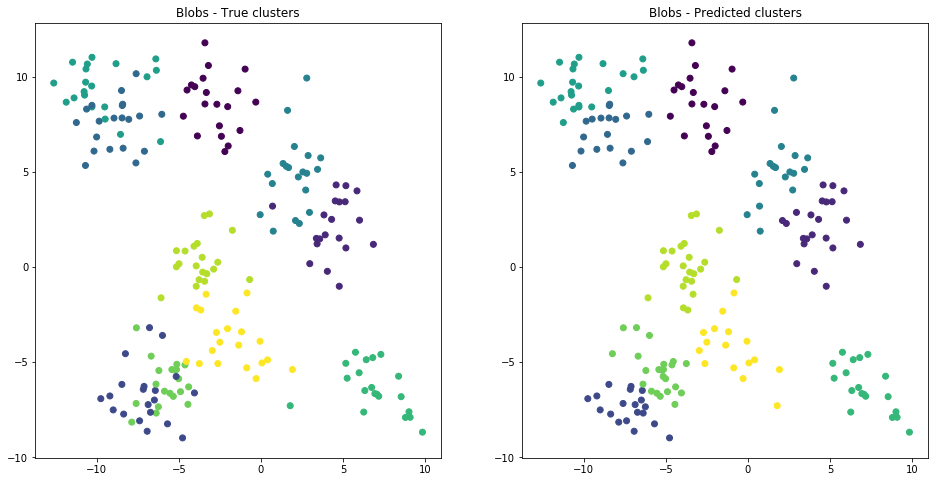

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title('Blobs - True clusters')
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[1].set_title('Blobs - Predicted clusters')
ax[1].scatter(X[:,0], X[:,1], c=blobs_match_labels)
plt.show()

#### Metrics

Accuracy: 0.865


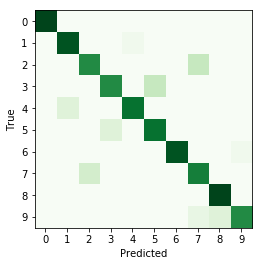

In [6]:
from sklearn import metrics

# Accuracy
print('Accuracy: %s' % metrics.accuracy_score(y, blobs_match_labels))

# Confusion matrix
plt.imshow(metrics.confusion_matrix(y, blobs_match_labels), cmap='Greens')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.yticks([i for i in range(0,10)])
plt.xticks([i for i in range(0,10)])
plt.show()

__________________________
# Image clustering

#### Configuration

In [7]:
nb_clusters = 10

#### Load dataset

In [8]:
from sklearn.datasets import load_digits

mnist = load_digits()

#### Create model, fit and predict

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=nb_clusters)
kmeans.fit(mnist.data)
y_pred = kmeans.predict(mnist.data)

#### Plot centers of all clusters

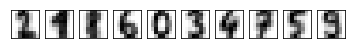

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
for i in range(10):
    ax = fig.add_subplot(1, nb_clusters, 1 + i, xticks=[], yticks=[])
    ax.imshow(kmeans.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)
plt.show()

#### Match clusters with corresponding labels

In [11]:
import numpy as np
from scipy.stats import mode

mnist_match_labels = np.zeros_like(mnist.target)
for cluster in range(nb_clusters):
    mask = (y_pred==cluster)
    mnist_match_labels[mask] = mode(mnist.target[mask])[0]

#### PCA

In [12]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2 dimensions
X = PCA(2).fit_transform(mnist.data)

#### Plot results

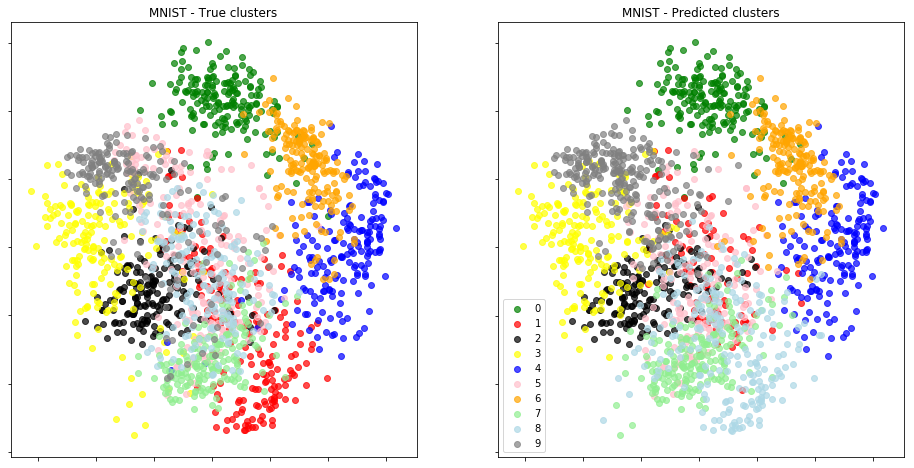

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
kwargs = dict(cmap = plt.cm.get_cmap('prism', nb_clusters), alpha=0.7)
colors = ['green', 'red', 'black', 'yellow', 'blue', 'pink', 'orange', 'lightgreen', 'lightblue', 'gray']

for class_, clr in zip(mnist.target_names, colors):
    
    # True
    idx = np.argwhere(mnist.target == class_)
    ax[0].scatter(X[idx[:,0],0], X[idx[:,0],1], color=clr, label=class_, **kwargs)
    ax[0].set_title('MNIST - True clusters')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    
    # Prediction
    idx = np.argwhere(mnist_match_labels == class_)
    ax[1].scatter(X[idx[:,0],0], X[idx[:,0],1], color=clr, label=class_, **kwargs)
    ax[1].set_title('MNIST - Predicted clusters')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])

plt.legend()
plt.show()

#### Metrics

Accuracy: 0.7941012799109627


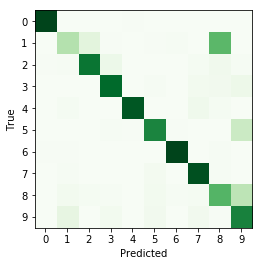

In [14]:
from sklearn import metrics

# Accuracy
print('Accuracy:', metrics.accuracy_score(mnist.target, mnist_match_labels))

# Confusion matrix
plt.imshow(metrics.confusion_matrix(mnist.target, mnist_match_labels), cmap='Greens')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.yticks([i for i in range(0,10)])
plt.xticks([i for i in range(0,10)])
plt.show()

______________________________
# Text clustering
As you can see below, it's quit hard to learn in an unsupervised learning to distinguish into good and bad texts.

In [15]:
nb_clusters = 2

#### Load dataset 

In [16]:
import os

def read_files(path):
    documents = list()
    for filename in os.listdir(path):
        with open('%s/%s' % (path, filename)) as f:
            doc = f.read()
            documents.append(doc)
    return documents


negative_docs =  read_files('data/imdb/train/neg')
positive_docs =  read_files('data/imdb/train/pos')

docs   = negative_docs + positive_docs
labels = [0 for _ in range(len(negative_docs))] + [1 for _ in range(len(positive_docs))]

print('Training samples: %i' % len(docs))

Training samples: 25000


#### Vectorize documents

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(
    max_features = 19000,
    max_df       = 400,
    sublinear_tf = True,
    use_idf      = True,
    ngram_range  = (1,1),
    lowercase    = False
)

docs_vec = vectorizer.fit_transform(docs)

In [18]:
docs_vec.shape

(25000, 19000)

#### Create model and fit the data

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=nb_clusters, n_jobs=25)
y_pred = kmeans.fit_transform(docs_vec)

#### Top terms per cluster

In [20]:
print("*** Top terms per cluster ***")

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(nb_clusters):
    print("Cluster %d:\n" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s\n' % terms[ind], end='')
    print()
    print()

*** Top terms per cluster ***
Cluster 0:
 season
 laughed
 awesome
 Please
 slasher
 fi
 monster
 bother
 zombie
 sci


Cluster 1:
 outstanding
 beautifully
 Jane
 culture
 dancing
 adaptation
 scenery
 Scott
 emotions
 stunning




#### Cluster

In [21]:
import collections
import random

clusters = collections.defaultdict(list)
for text_id, label in enumerate(kmeans.labels_):
    clusters[label].append(text_id)

for cluster_id in clusters.keys():
    print( "#"*30+"\nCluster %i - with %i entries\n" % 
           (cluster_id, len(clusters[cluster_id])) +"#"*30)
    random_ids = random.sample(clusters[cluster_id], 1)
    for doc_id in random_ids:
        print ("\n" + 'Text:\n' + docs[doc_id], '\nLabel:',labels[doc_id])
    print("\n\n")

##############################
Cluster 0 - with 11508 entries
##############################

Text:
Super Mario 64 is undoubtedly the greatest game ever created. It is so addicting that you could play it for hours upon hours without stopping for a break. I've beaten the game 4 times, but I've never gotten all 120 stars...(I've gotten 111)...but I hope to achieve them eventually. Even though I didn't officially play this game until I was seven in, I loved watching my sisters play it. Now I am 13 and still play this, erasing games and starting over again.<br /><br />The graphics are unbelievable for an early N64 game. The gameplay is addictive. The controls are great. The levels are tough, but not impossible. The Bowser fights are challenging.<br /><br />I would like to tell you more, but why don't you just get it for yourself? Put the X-BOX 360, PS3, and the Wii away and go find yourself a Nintendo 64 and play this amazing, wonderful game. 
Label: 1



##############################
Clu

In [22]:
import numpy as np
from scipy.stats import mode

doc_match_labels = np.zeros_like(labels)
for i in range(nb_clusters):
    mask = (np.argmax(y_pred, axis=-1)==i)
    doc_match_labels[mask] = mode(np.array(labels)[mask])[0]

#### Reduce dimensionality

In [23]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
X   = svd.fit_transform(docs_vec)

#### Plot results

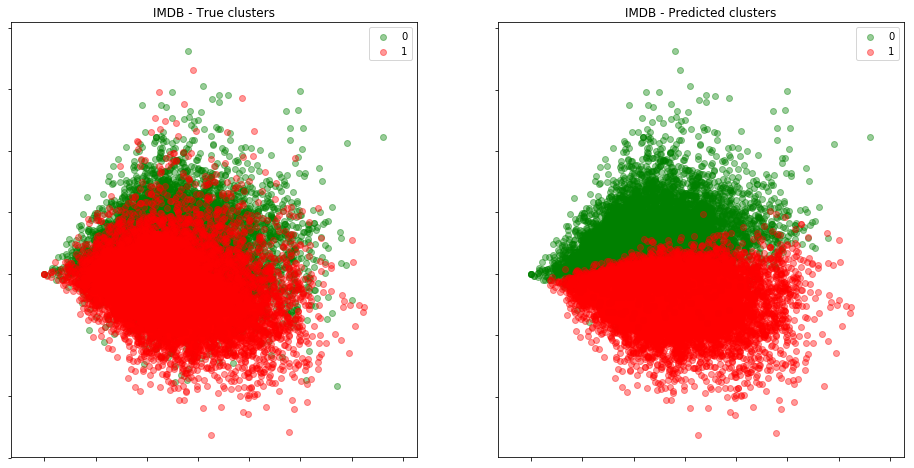

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
kwargs = dict(cmap = plt.cm.get_cmap('prism', nb_clusters), alpha=0.4)
colors = ['green', 'red']

for class_, clr in zip([0,1], colors):
    
    # True
    idx = np.argwhere(np.array(labels) == class_)
    ax[0].scatter(X[idx[:,0],0], X[idx[:,0],1], color=clr, label=class_, **kwargs)
    ax[0].set_title('IMDB - True clusters')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].legend()
    
    # Prediction
    idx = np.argwhere(doc_match_labels == class_)
    ax[1].scatter(X[idx[:,0],0], X[idx[:,0],1], color=clr, label=class_, **kwargs)
    ax[1].set_title('IMDB - Predicted clusters')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].legend()

plt.show()

#### Metrics

0.68032


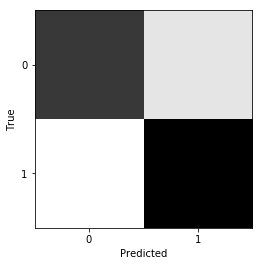

In [25]:
from sklearn import metrics

print(metrics.accuracy_score(doc_match_labels, labels))

# Confusion matrix
plt.imshow(metrics.confusion_matrix(y_pred=doc_match_labels, y_true=labels), cmap='Greys')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.yticks([i for i in range(0,2)])
plt.xticks([i for i in range(0,2)])
plt.show()